## Section 1 — Load Alerts

Loads alerts generated by the WHALE FAN-OUT BURST KPI.
This KPI detects wallets that:

send funds to many distinct recipients

within a short time window

with large total USD outflow

This may indicate wash distribution, scam payouts, or mixer-style dispersal.

In [5]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# connect to DB
BASE_DIR = Path.cwd().parents[0]
DB_PATH = BASE_DIR / "db" / "crypto_fraud.db"
conn = sqlite3.connect(DB_PATH)

df_alerts = pd.read_sql_query(
    """
    SELECT
      wallet_id,
      chain,
      details,
      created_at
    FROM alerts
    WHERE kpi_name = 'WHALE_FAN_OUT_BURST'
    ORDER BY created_at DESC
    """,
    conn,
)

df_alerts.head(10)


,wallet_id,chain,details,created_at
0,0x46340b20830761efd32832a74d7169b29feb9758,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:31:24.699570Z
1,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:31:24.699570Z
2,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,ethereum,"distinct_recipients=5, total_outflow_usd=1122....",2025-12-27T11:31:24.699570Z
3,0x46340b20830761efd32832a74d7169b29feb9758,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:30:56.881312Z
4,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:30:56.881312Z
5,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,ethereum,"distinct_recipients=5, total_outflow_usd=1122....",2025-12-27T11:30:56.881312Z


## Section 2 — Parse Fields

Converts KPI metadata into numeric columns for analysis:

distinct recipients count

total USD outflow

time window

These values allow us to analyze distribution and identify fan-out intensity.

In [7]:
def parse_details(details):
    """
    Parse KPI 'details' field from alerts table into dict values.
    Example format:
    'distinct_recipients=7, total_outflow_usd=1832.22, window_hours=24'
    """
    parts = details.split(", ")
    parsed = {}
    
    for p in parts:
        key, value = p.split("=")
        try:
            parsed[key] = float(value)
        except ValueError:
            parsed[key] = value  # fallback (string)
    
    return parsed


parsed = df_alerts["details"].apply(parse_details).tolist()
metrics = pd.DataFrame(parsed)

df = pd.concat([df_alerts, metrics], axis=1)
df.head(5)


,wallet_id,chain,details,created_at,distinct_recipients,total_outflow_usd,window_hours
0,0x46340b20830761efd32832a74d7169b29feb9758,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:31:24.699570Z,8.0,2657.09,24.0
1,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:31:24.699570Z,10.0,4047.15,24.0
2,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,ethereum,"distinct_recipients=5, total_outflow_usd=1122....",2025-12-27T11:31:24.699570Z,5.0,1122.56,24.0
3,0x46340b20830761efd32832a74d7169b29feb9758,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:30:56.881312Z,8.0,2657.09,24.0
4,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:30:56.881312Z,10.0,4047.15,24.0


## Section 3 — Aggregate Risky Wallets:

Groups alerts per wallet in order to identify:

wallets repeatedly performing burst-style distributions

average number of receiving wallets

total average USD outflow

Repeated burst fan-out patterns may indicate:

scam payment routing

obfuscation before bridge / exchange transfer

In [8]:
df_summary = (
    df.groupby(["wallet_id", "chain"])
      .agg(
          alerts_count=("wallet_id", "count"),
          avg_recipients=("distinct_recipients", "mean"),
          avg_outflow_usd=("total_outflow_usd", "mean")
      )
      .reset_index()
      .sort_values("alerts_count", ascending=False)
)

df_summary.head(10)


,wallet_id,chain,alerts_count,avg_recipients,avg_outflow_usd
0,0x46340b20830761efd32832a74d7169b29feb9758,ethereum,2,8.0,2657.09
1,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,ethereum,2,10.0,4047.15
2,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,ethereum,2,5.0,1122.56


## Section 4 — Bar Chart — Fan-Out Wallets

Wallets at the top of this chart represent:

high-activity outbound hubs

potential distribution wallets for fraud / laundering networks

The more alerts a wallet generates —
the stronger the behavioral signal.

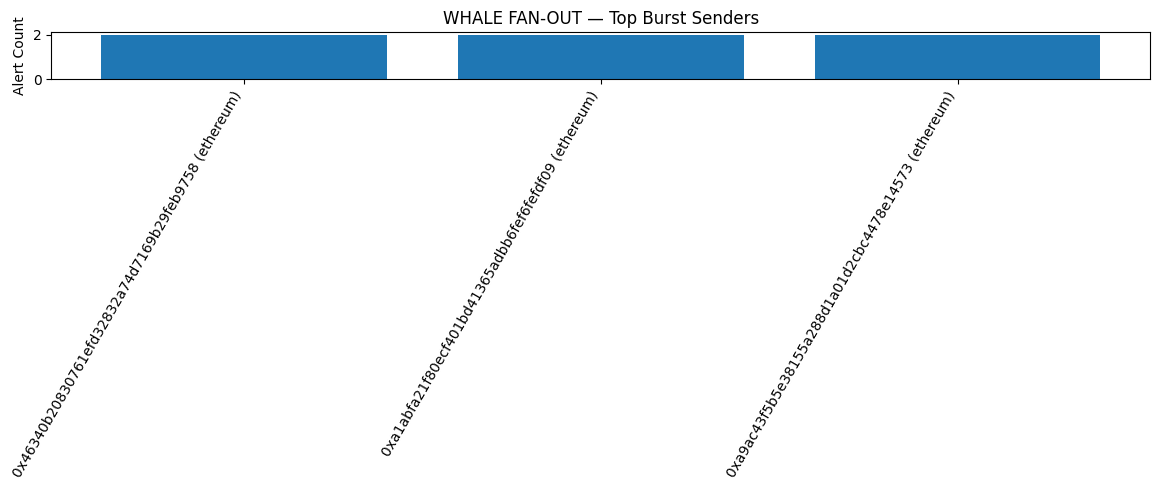

In [9]:
plt.figure(figsize=(12,5))

x = df_summary["wallet_id"] + " (" + df_summary["chain"] + ")"
plt.bar(x, df_summary["alerts_count"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Alert Count")
plt.title("WHALE FAN-OUT — Top Burst Senders")
plt.tight_layout()
plt.show()


## Section 5 — Outflow Volume Chart

Highlights high-value whales distributing large amounts in bursts.

Typical risk signals include:

repeated burst transfers at similar timing

high USD value per event

many unique recipients

These patterns are common in payout routing, pyramid scams, and reward-style fraud flows.

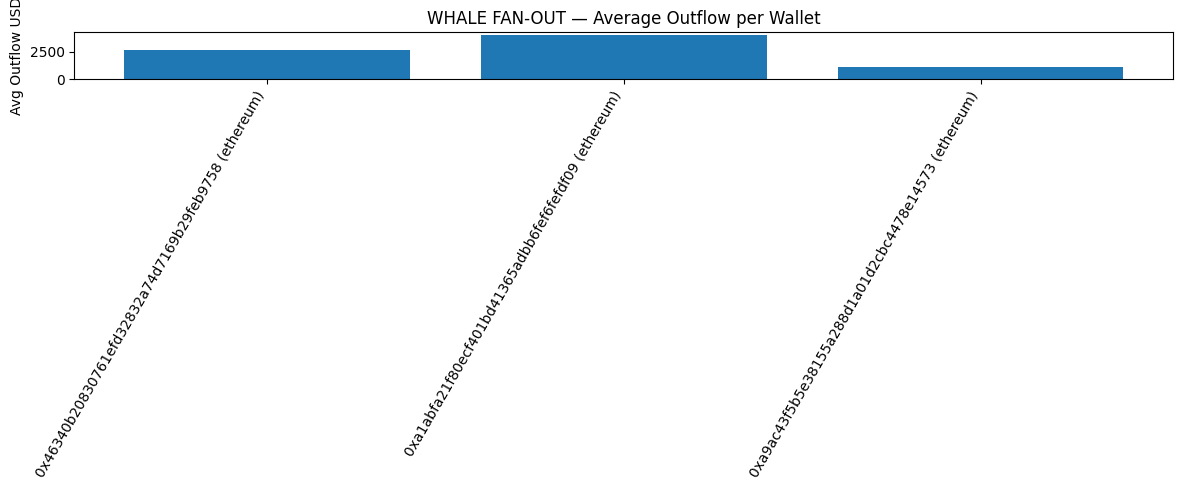

In [10]:
plt.figure(figsize=(12,5))
plt.bar(x, df_summary["avg_outflow_usd"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Avg Outflow USD")
plt.title("WHALE FAN-OUT — Average Outflow per Wallet")
plt.tight_layout()
plt.show()
